In [74]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

## Importing data set 

In [8]:
readRDS = robjects.r['readRDS']
df = readRDS('loan_data.rds')
df = pandas2ri.ri2py(df)

## Describing data set 

In [9]:
df.describe(include=[np.object])

,grade,home_ownership,emp_cat,ir_cat
count,29091,29091,29091,29091
unique,7,4,5,5
top,A,RENT,0-15,0-8
freq,9649,14692,25642,7130


In [10]:
df.describe(include=[np.number])

,loan_status,loan_amnt,annual_inc,age
count,29091.000000,29091.000000,2.909100e+04,29091.000000
mean,0.110928,9593.663848,6.696489e+04,27.698120
std,0.314048,6323.467488,5.325318e+04,6.194617
min,0.000000,500.000000,4.000000e+03,20.000000
25%,0.000000,5000.000000,4.000000e+04,23.000000
50%,0.000000,8000.000000,5.640000e+04,26.000000
75%,0.000000,12250.000000,8.000000e+04,30.000000
max,1.000000,35000.000000,2.039784e+06,94.000000


In [118]:
l = df.select_dtypes(exclude=[object]).shape[1]
n = int(np.floor(np.sqrt(l)))
m = int(np.ceil(l / n))

In [123]:
ax.flatten()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffaa37a5b70>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7ffaa3725b70>], dtype=object)

<IPython.core.display.Javascript object>


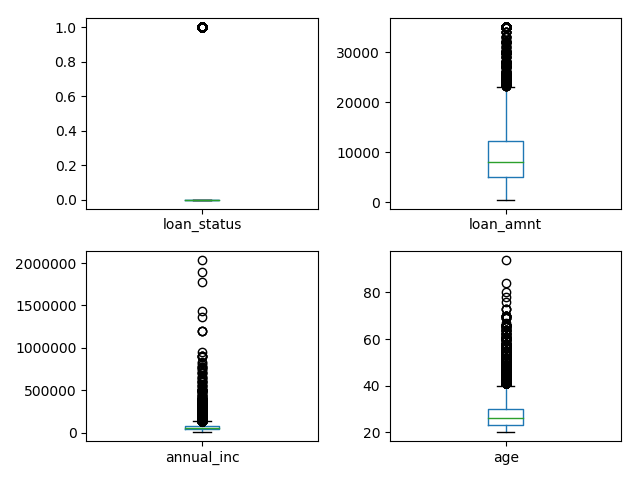

In [134]:
f, ax = plt.subplots(n,m)
ax = ax.flatten()
i = 0
for col in df.select_dtypes(exclude=[object]).iteritems():
    col[1].plot(kind='box', ax = ax[i])
    i = i + 1
plt.tight_layout()

In [67]:
df.groupby("loan_status").aggregate([np.mean, np.std])

loan_amnt                 annual_inc                      age  \
                    mean          std          mean           std       mean   
loan_status                                                                    
0            9619.234264  6307.620056  67937.626557  54029.038933  27.733955   
1            9388.720174  6446.406294  59168.548119  45837.568727  27.410908   

                       
                  std  
loan_status            
0            6.208826  
1            6.072846

## Getting dummy variables

In [142]:
df = pd.get_dummies(df)

In [143]:
df.columns

Index(['loan_status', 'loan_amnt', 'annual_inc', 'age', 'grade_A', 'grade_B',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'emp_cat_0-15', 'emp_cat_15-30', 'emp_cat_30-45',
       'emp_cat_45+', 'emp_cat_Missing', 'ir_cat_0-8', 'ir_cat_11-13.5',
       'ir_cat_13.5+', 'ir_cat_8-11', 'ir_cat_Missing'],
      dtype='object')

In [100]:
table = pd.crosstab(df["grade"], df["loan_status"], normalize=True)
#table.div(table.sum(1), axis=0).plot(kind='bar', stacked=True)

In [13]:
from sklearn.linear_model import LogisticRegressionCV

In [14]:
model = LogisticRegressionCV()


In [150]:
list(df.columns)

['loan_status',
 'loan_amnt',
 'annual_inc',
 'age',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'home_ownership_MORTGAGE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'emp_cat_0-15',
 'emp_cat_15-30',
 'emp_cat_30-45',
 'emp_cat_45+',
 'emp_cat_Missing',
 'ir_cat_0-8',
 'ir_cat_11-13.5',
 'ir_cat_13.5+',
 'ir_cat_8-11',
 'ir_cat_Missing']

In [154]:
target = ["loan_status"]
features = [x for x in list(df.columns) if x not in target]

In [158]:
X = df[features]
y = np.ravel(df[target])

In [159]:
model.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [166]:
X.iloc[1]

loan_amnt                   2400.0
annual_inc                 12252.0
age                           31.0
grade_A                        0.0
grade_B                        0.0
grade_C                        1.0
grade_D                        0.0
grade_E                        0.0
grade_F                        0.0
grade_G                        0.0
home_ownership_MORTGAGE        0.0
home_ownership_OTHER           0.0
home_ownership_OWN             0.0
home_ownership_RENT            1.0
emp_cat_0-15                   0.0
emp_cat_15-30                  1.0
emp_cat_30-45                  0.0
emp_cat_45+                    0.0
emp_cat_Missing                0.0
ir_cat_0-8                     0.0
ir_cat_11-13.5                 0.0
ir_cat_13.5+                   0.0
ir_cat_8-11                    0.0
ir_cat_Missing                 1.0
Name: 2, dtype: float64

In [170]:
model.predict_proba(X.iloc[1].values.reshape(1,-1))

array([[ 0.86188899,  0.13811101]])

In [172]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y, y_pred=model.predict(X))

array([[25864,     0],
       [ 3227,     0]])

[Python implementation reference](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8)